In [1]:
#Dependecies 
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from wordcloud import WordCloud
from collections import Counter
from itertools import chain
import contractions
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from nltk import ngrams

In [2]:
df = pd.read_csv('data/mbti_1.csv')
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [4]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [5]:
y_label = df.type.unique()
print(y_label)

['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


In [6]:
def divide_types(df):
    df["E-I"] = ""
    df["N-S"] = ""
    df["F-T"] = ""
    df["J-P"] = ""
    for index, row in df.iterrows():
        row["E-I"] = "E" if row.type[0] == "E" else "I"
        row["N-S"] = "N" if row.type[1] == "N" else "S"
        row["F-T"] = "F" if row.type[2] == "F" else "T"
        row["J-P"] = "J" if row.type[3] == "J" else "P"
    return df

data = divide_types(df)

In [7]:
data

,type,posts,E-I,N-S,F-T,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,I,S,F,P
8671,ENFP,'So...if this thread already exists someplace ...,E,N,F,P
8672,INTP,'So many questions when i do these things. I ...,I,N,T,P
8673,INFP,'I am very conflicted right now when it comes ...,I,N,F,P


In [8]:
def clean_data(df, column_name = "posts", new_column="cleaned_post"):
    df[new_column] = df[column_name].apply(lambda x: contractions.fix(x))
    df[new_column] = df[new_column].apply(lambda x: x.lower())
    df[new_column] = df[new_column].apply(lambda x: re.sub(r'@([a-zA-Z0-9_]{1,50})', '', x))
    df[new_column] = df[new_column].apply(lambda x: re.sub(r'#([a-zA-Z0-9_]{1,50})', '', x))
    df[new_column] = df[new_column].apply(lambda x: re.sub(r'http[s]?://\S+', '', x))
    df[new_column]= df[new_column].apply(lambda x: re.sub(r'[^A-Za-z]+', ' ', x))
    df[new_column] = df[new_column].apply(lambda x: re.sub(r' +', ' ', x))
    df[new_column] = df[new_column].apply(lambda x: " ".join([word for word in x.split() if not len(word) <3]))
    return df

cleaned_df = clean_data(data)

In [9]:
cleaned_df.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,and intj moments sportscenter not top ten play...
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding the lack these posts very alarming sex...
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course which say know that blessing a...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed our conversation the other d...
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,you are fired that another silly misconception...


In [10]:


cleaned_df["words_count"] = cleaned_df["cleaned_post"].apply(lambda x: len(x.split()))
cleaned_df.head(5)

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,and intj moments sportscenter not top ten play...,454
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding the lack these posts very alarming sex...,874
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course which say know that blessing a...,653
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed our conversation the other d...,820
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,you are fired that another silly misconception...,782


In [11]:

training_data = data[["cleaned_post", "E-I", "N-S", "F-T", "J-P"]].copy()
training_data.head(5)

,cleaned_post,E-I,N-S,F-T,J-P
0,and intj moments sportscenter not top ten play...,I,N,F,J
1,finding the lack these posts very alarming sex...,E,N,T,P
2,good one course which say know that blessing a...,I,N,T,P
3,dear intp enjoyed our conversation the other d...,I,N,T,J
4,you are fired that another silly misconception...,E,N,T,J


In [12]:
def make_dummies(data, columns=["E-I", "N-S", "F-T", "J-P"]):
    for column in columns:
        temp_dummy = pd.get_dummies(data[column])
        data = data.join(temp_dummy)
    return data
     

In [13]:
training_data = make_dummies(training_data)
training_data.head()

,cleaned_post,E-I,N-S,F-T,J-P,E,I,N,S,F,T,J,P
0,and intj moments sportscenter not top ten play...,I,N,F,J,0,1,1,0,1,0,1,0
1,finding the lack these posts very alarming sex...,E,N,T,P,1,0,1,0,0,1,0,1
2,good one course which say know that blessing a...,I,N,T,P,0,1,1,0,0,1,0,1
3,dear intp enjoyed our conversation the other d...,I,N,T,J,0,1,1,0,0,1,1,0
4,you are fired that another silly misconception...,E,N,T,J,1,0,1,0,0,1,1,0


In [14]:
X = training_data[["cleaned_post"]]
y = training_data.drop(columns=["cleaned_post"])

In [15]:
X

,cleaned_post
0,and intj moments sportscenter not top ten play...
1,finding the lack these posts very alarming sex...
2,good one course which say know that blessing a...
3,dear intp enjoyed our conversation the other d...
4,you are fired that another silly misconception...
...,...
8670,just because always think cats doms for some r...
8671,this thread already exists someplace else whic...
8672,many questions when these things would take th...
8673,very conflicted right now when comes wanting c...


In [16]:
y

,E-I,N-S,F-T,J-P,E,I,N,S,F,T,J,P
0,I,N,F,J,0,1,1,0,1,0,1,0
1,E,N,T,P,1,0,1,0,0,1,0,1
2,I,N,T,P,0,1,1,0,0,1,0,1
3,I,N,T,J,0,1,1,0,0,1,1,0
4,E,N,T,J,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8670,I,S,F,P,0,1,0,1,1,0,0,1
8671,E,N,F,P,1,0,1,0,1,0,0,1
8672,I,N,T,P,0,1,1,0,0,1,0,1
8673,I,N,F,P,0,1,1,0,1,0,0,1


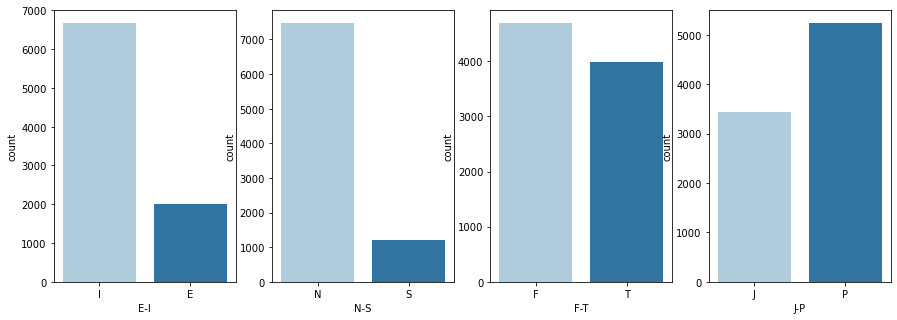

In [33]:
def show_distribution(data, x=["E-I", "N-S", "F-T","J-P"], fig_size=(15,5), xticks_size=10, palette="Paired"):
    fig, ax = plt.subplots(len(x), figsize=fig_size)
    j = 0
    for _x in x:
        plt.subplot(1,4, j+1)
        sns.countplot(x=_x, data=data, palette=palette)
        plt.xticks(size=xticks_size)
        j+=1    
        
show_distribution(data)

In [18]:
!pip install imblearn

In [19]:
from imblearn.over_sampling import RandomOverSampler

In [20]:
oversample = RandomOverSampler()

In [21]:
y_ei = y["E"]
y_ns = y["N"]
y_ft = y["F"]
y_jp = y["J"]

In [22]:
X_over_ei, y_over_ei = oversample.fit_resample(X, y_ei)
X_over_ns, y_over_ns = oversample.fit_resample(X, y_ns)
X_over_ft, y_over_ft = oversample.fit_resample(X, y_ft)
X_over_jp, y_over_jp = oversample.fit_resample(X, y_jp)





In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train_ei, X_test_ei, y_train_ei, y_test_ei = train_test_split(X_over_ei, y_over_ei, test_size=0.3, random_state=42)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_over_ns, y_over_ns, test_size=0.3, random_state=42)
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_over_ft, y_over_ft, test_size=0.3, random_state=42)
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X_over_jp, y_over_jp, test_size=0.3, random_state=42)

In [25]:
X_train_ei = X_train_ei['cleaned_post']
X_train_ns = X_train_ns['cleaned_post']
X_train_ft = X_train_ft['cleaned_post']
X_train_jp = X_train_jp['cleaned_post']
     

In [26]:
X_test_ei = X_test_ei['cleaned_post']
X_test_ns = X_test_ns['cleaned_post']
X_test_ft = X_test_ft['cleaned_post']
X_test_jp = X_test_jp['cleaned_post']

In [27]:
y_train_ei.name, y_test_ei.name = "E-I", "E-I"
y_train_ns.name, y_test_ns.name = "N-S", "N-S"
y_train_ft.name, y_test_ft.name = "F-T", "F-T"
y_train_jp.name, y_test_jp.name = "J-P", "J-P"

In [28]:
y_all_train = [y_train_ei, y_train_ns, y_train_ft,  y_train_jp]
y_all_test  = [y_test_ei, y_test_ns, y_test_ft, y_test_jp] 

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
     

vectorizer = TfidfVectorizer(max_features=10000)
     

vectorizer.fit(X_train_ei)
     
TfidfVectorizer(max_features=10000)

X_train_ei = vectorizer.transform(X_train_ei)
X_test_ei  = vectorizer.transform(X_test_ei)

X_train_ns = vectorizer.transform(X_train_ns)
X_test_ns  = vectorizer.transform(X_test_ns)

X_train_ft = vectorizer.transform(X_train_ft)
X_test_ft  = vectorizer.transform(X_test_ft)

X_train_jp = vectorizer.transform(X_train_jp)
X_test_jp  = vectorizer.transform(X_test_jp)
     

x_all_train = [X_train_ei, X_train_ns, X_train_ft, X_train_jp]
x_all_test  = [X_test_ei, X_test_ns, X_test_ft, X_test_jp]
     

tf_idf = pd.DataFrame(X_test_ei.toarray(), columns=vectorizer.get_feature_names_out())
tf_idf.head(10)

,aaaand,aback,abandon,abandoned,abilities,ability,able,abnormal,aboard,abortion,...,zero,zodiac,zoe,zombie,zombies,zone,zoned,zoning,zoo,zoom
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.014857,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.081869,0.0,0.0,0.0,0.031577,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.025206,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.038577,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.023225,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
import pickle
from sklearn import metrics

In [31]:
def create_models():
    nb_clf  = MultinomialNB(alpha=0.01)
    lr_clf = LogisticRegression(max_iter=100)
    svm_clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    dt_clf  = DecisionTreeClassifier(max_depth=7)
    rf_clf  = RandomForestClassifier(n_estimators=750)
    xgb_clf = xgboost.XGBClassifier(use_label_encoder=False)
    return {"NaiveBayes":nb_clf, "Logistic Regression": lr_clf, "SVM":svm_clf, "DecisionTree":dt_clf, "RandomForest":rf_clf, "Xgboost":xgb_clf}

In [32]:
_metrics = ["Accuracy", "Accuracy", "Accuracy" ,"Accuracy", "Precision", "Precision", "Precision","Precision", "Recall","Recall","Recall","Recall", "F1-Score", "F1-Score", "F1-Score", "F1-Score", "Roc-Auc Score", "Roc-Auc Score", "Roc-Auc Score", "Roc-Auc Score"]
_types   = ["E-I", "N-S", "F-T", "J-P", "E-I", "N-S", "F-T", "J-P", "E-I", "N-S", "F-T", "J-P","E-I", "N-S", "F-T", "J-P","E-I", "N-S", "F-T", "J-P"]
_columns = ["NaiveBayes","Logistic Regression",  "SVM", "DecisionTree", "RandomForest", "Xgboost"]
     

In [33]:
evaluation_df = pd.DataFrame(columns=_columns, index=[_metrics, _types])
evaluation_df

NaiveBayes Logistic Regression  SVM DecisionTree  \
Accuracy      E-I        NaN                 NaN  NaN          NaN   
              N-S        NaN                 NaN  NaN          NaN   
              F-T        NaN                 NaN  NaN          NaN   
              J-P        NaN                 NaN  NaN          NaN   
Precision     E-I        NaN                 NaN  NaN          NaN   
              N-S        NaN                 NaN  NaN          NaN   
              F-T        NaN                 NaN  NaN          NaN   
              J-P        NaN                 NaN  NaN          NaN   
Recall        E-I        NaN                 NaN  NaN          NaN   
              N-S        NaN                 NaN  NaN          NaN   
              F-T        NaN                 NaN  NaN          NaN   
              J-P        NaN                 NaN  NaN          NaN   
F1-Score      E-I        NaN                 NaN  NaN          NaN   
              N-S        NaN                 NaN  NaN          NaN   
              F-T        NaN                 NaN  NaN          NaN   
              J-P        NaN                 NaN  NaN          NaN   
Roc-Auc Score E-I        NaN                 NaN  NaN          NaN   
              N-S        NaN                 NaN  NaN          NaN   
              F-T        NaN                 NaN  NaN          NaN   
              J-P        NaN                 NaN  NaN          NaN   

                  RandomForest Xgboost  
Accuracy      E-I          NaN     NaN  
              N-S          NaN     NaN  
              F-T          NaN     NaN  
              J-P          NaN     NaN  
Precision     E-I          NaN     NaN  
              N-S          NaN     NaN  
              F-T          NaN     NaN  
              J-P          NaN     NaN  
Recall        E-I          NaN     NaN  
              N-S          NaN     NaN  
              F-T          NaN     NaN  
              J-P          NaN     NaN  
F1-Score      E-I          NaN     NaN  
              N-S          NaN     NaN  
              F-T          NaN     NaN  
              J-P          NaN     NaN  
Roc-Auc Score E-I          NaN     NaN  
              N-S          NaN     NaN  
              F-T          NaN     NaN  
              J-P          NaN     NaN

In [34]:
models = create_models()
models

/Users/maidang/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'NaiveBayes': MultinomialNB(alpha=0.01),
 'Logistic Regression': LogisticRegression(),
 'SVM': SVC(gamma='auto', kernel='linear'),
 'DecisionTree': DecisionTreeClassifier(max_depth=7),
 'RandomForest': RandomForestClassifier(n_estimators=750),
 'Xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, rando

In [35]:
for model_item in models.items():
    for X_train, X_test, y_train, y_test in zip(x_all_train, x_all_test, y_all_train, y_all_test):
        # Model creation and prediction
        model = model_item[1]
        print(f"{model} is training for {y_train.name}...")
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        # Performance evaluation metrics
        evaluation_df.loc["Accuracy",y_train.name][model_item[0]]      = round(metrics.accuracy_score(y_test, pred), 3)
        evaluation_df.loc["Precision",y_train.name][model_item[0]]     = round(metrics.precision_score(y_test, pred), 3)
        evaluation_df.loc["Recall",y_train.name][model_item[0]]        = round(metrics.recall_score(y_test, pred), 3)        
        evaluation_df.loc["F1-Score",y_train.name][model_item[0]]      = round(metrics.f1_score(y_test, pred), 3)
        evaluation_df.loc["Roc-Auc Score",y_train.name][model_item[0]] = round(metrics.roc_auc_score(y_test, pred), 3)        
        # Save model
        filename = f'models/{model_item[0]}_{y_test.name}.sav'
        print(filename)
        pickle.dump(model,open(filename, 'wb'))
     

MultinomialNB(alpha=0.01) is training for E-I...
models/NaiveBayes_E-I.sav
MultinomialNB(alpha=0.01) is training for N-S...
models/NaiveBayes_N-S.sav
MultinomialNB(alpha=0.01) is training for F-T...
models/NaiveBayes_F-T.sav
MultinomialNB(alpha=0.01) is training for J-P...
models/NaiveBayes_J-P.sav
LogisticRegression() is training for E-I...
models/Logistic Regression_E-I.sav
LogisticRegression() is training for N-S...
models/Logistic Regression_N-S.sav
LogisticRegression() is training for F-T...
models/Logistic Regression_F-T.sav
LogisticRegression() is training for J-P...
models/Logistic Regression_J-P.sav
SVC(gamma='auto', kernel='linear') is training for E-I...
models/SVM_E-I.sav
SVC(gamma='auto', kernel='linear') is training for N-S...
models/SVM_N-S.sav
SVC(gamma='auto', kernel='linear') is training for F-T...
models/SVM_F-T.sav
SVC(gamma='auto', kernel='linear') is training for J-P...
models/SVM_J-P.sav
DecisionTreeClassifier(max_depth=7) is training for E-I...
models/DecisionTr

In [36]:
evaluation_df

NaiveBayes Logistic Regression    SVM DecisionTree  \
Accuracy      E-I      0.817               0.868  0.887        0.778   
              N-S      0.896               0.917  0.941        0.804   
              F-T      0.819               0.853  0.859        0.764   
              J-P      0.723               0.817  0.817        0.725   
Precision     E-I      0.824               0.879  0.888        0.773   
              N-S      0.896               0.925  0.958        0.766   
              F-T      0.818               0.855   0.86        0.765   
              J-P       0.72               0.818  0.811        0.762   
Recall        E-I      0.808               0.856  0.887         0.79   
              N-S      0.898                0.91  0.923        0.882   
              F-T      0.819               0.849  0.858         0.76   
              J-P      0.724               0.811  0.825        0.649   
F1-Score      E-I      0.816               0.867  0.887        0.781   
              N-S      0.897               0.917   0.94         0.82   
              F-T      0.819               0.852  0.859        0.762   
              J-P      0.722               0.815  0.818        0.701   
Roc-Auc Score E-I      0.817               0.868  0.887        0.778   
              N-S      0.896               0.917  0.941        0.804   
              F-T      0.819               0.853  0.859        0.764   
              J-P      0.723               0.817  0.818        0.725   

                  RandomForest Xgboost  
Accuracy      E-I        0.952   0.938  
              N-S        0.992   0.967  
              F-T        0.845   0.849  
              J-P        0.824   0.849  
Precision     E-I         0.99   0.918  
              N-S         0.99   0.993  
              F-T        0.837   0.848  
              J-P        0.901   0.841  
Recall        E-I        0.913   0.964  
              N-S        0.995   0.941  
              F-T        0.856   0.849  
              J-P        0.725   0.858  
F1-Score      E-I         0.95    0.94  
              N-S        0.993   0.966  
              F-T        0.847   0.849  
              J-P        0.803    0.85  
Roc-Auc Score E-I        0.952   0.938  
              N-S        0.992   0.967  
              F-T        0.845   0.849  
              J-P        0.823   0.849

# Conclusion: 
Best Models: 
### E/I: Random Forest 95% 
### N/S Random Forest: 99%
### F/T: SVM 86%
### P XgBoost 85

In [37]:
stopword = stopwords.words("english")

In [38]:
def get_ngrams(data, n_gram, new_column, column="cleaned_post"):
    data["tokenized"]  = data[column].apply(lambda x: x.split())
    data["sw_removal"] = data["tokenized"].apply(lambda x: [y for y in x if not y in stopword])
    data[new_column]   = data["sw_removal"].apply(lambda x: list(ngrams(x, n_gram)))
    data.drop(columns  = ["tokenized", "sw_removal"], inplace=True)
    return data

In [39]:
data = get_ngrams(cleaned_df, n_gram=2, new_column="bigrams")
data.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,bigrams
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,and intj moments sportscenter not top ten play...,454,"[(intj, moments), (moments, sportscenter), (sp..."
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding the lack these posts very alarming sex...,874,"[(finding, lack), (lack, posts), (posts, alarm..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course which say know that blessing a...,653,"[(good, one), (one, course), (course, say), (s..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed our conversation the other d...,820,"[(dear, intp), (intp, enjoyed), (enjoyed, conv..."
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,you are fired that another silly misconception...,782,"[(fired, another), (another, silly), (silly, m..."


In [40]:
data = get_ngrams(data, n_gram=3, new_column="trigrams")
data.head()

,type,posts,E-I,N-S,F-T,J-P,cleaned_post,words_count,bigrams,trigrams
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,and intj moments sportscenter not top ten play...,454,"[(intj, moments), (moments, sportscenter), (sp...","[(intj, moments, sportscenter), (moments, spor..."
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,finding the lack these posts very alarming sex...,874,"[(finding, lack), (lack, posts), (posts, alarm...","[(finding, lack, posts), (lack, posts, alarmin..."
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one course which say know that blessing a...,653,"[(good, one), (one, course), (course, say), (s...","[(good, one, course), (one, course, say), (cou..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoyed our conversation the other d...,820,"[(dear, intp), (intp, enjoyed), (enjoyed, conv...","[(dear, intp, enjoyed), (intp, enjoyed, conver..."
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,you are fired that another silly misconception...,782,"[(fired, another), (another, silly), (silly, m...","[(fired, another, silly), (another, silly, mis..."


In [ ]:
data.to_csv('cleaned_df.csv')

In [43]:
filename = 'vectorizer/vectorizer.pkl'
pickle.dump(vectorizer,open(filename, 'wb'))